# Лабораторная работа № 4
### Минимальная оценка - 3 балла
### Максимальная оценка - 5 балла
Цель работы: реализация алгоритма кластеризации данных.

Для успешной сдачи лабораторной работы Вам необходимо предоставить заполненый исходный ноутбук, продемострировать процесс выполнения работы и ответить на дополнительные вопросы преподавателя.

### Описание датасета:
Датасет представляет собой объёмную базу данных образцов рукописного написания цифр. База данных является стандартом, предложенным Национальным институтом стандартов и технологий США с целью калибрации и сопоставления методов распознавания изображений с помощью машинного обучения.

### Загрузка датасета

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

In [2]:
X=digits.data
y=digits.target

In [3]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


## Задание 1 (3 балла).

### Задание 1.1
Разделите исходную выборку на обучающую и тестовую выборки (в соотношении 7:3) (параметр $random\_state=N$, где $N$ - ваш номер в списке группы).

In [4]:
N = 10

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=N, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1257, 64), (540, 64), (1257,), (540,))

### Задание 1.2

Пользуясь материалами лекции, реализуйте свой алгоритм **k-Means**, который в качестве входных параметров принимает $X, n\_clusters, iter\_num$, где $X$ - обучающая выборка из **задания 1.1**, $n\_clusters$ - количество кластеров, $iter\_num$ - ограничение для внутреннего цикла алгоритма **k-Means**.

Результатом работы вашего алгоритма должен быть массив ([numpy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html)), размером $n\_clusters$, элементами которого являются центры полученных кластеров.

In [7]:
import numpy as np
import sys

In [8]:
class TemplateKMeans(object):
    def __init__(self, init_centroids, n_clusters, iter_num=50):
        self._n_clusters = n_clusters
        self._iter_num   = iter_num
        self._controids  = None
        self._init_centroids = init_centroids
    
    def fit(self, X):
        self._centroids = self._init_centroids(X, self._n_clusters)
        
        for i in range(self._iter_num):
            old_centroids   = self._centroids
            distances       = self._compute_distances(X, old_centroids)
            self._centroids = self._renew_centroids(X, np.argmin(distances, axis=1))
            
            if np.all(old_centroids == self._centroids):
                break
    
    def predict(self, X):
        return np.argmin(self._compute_distances(X, self._centroids), 
                         axis=1)
        

    def _renew_centroids(self, X, labels):
        centroids = np.zeros((self._n_clusters, X.shape[1]))
        
        for k in range(self._n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
            
        return centroids

    def _compute_distances(self, X, centroids):
        distances = np.zeros((X.shape[0], self._n_clusters))
        
        for k in range(self._n_clusters):
            distances[:, k] = np.square(
                np.linalg.norm(X - centroids[k, :], axis=1))
            
        return distances

In [9]:
class KMeans(TemplateKMeans):
    def __init__(self, n_clusters, iter_num=50):
        super(KMeans, self).__init__(KMeans._init_centroids, 
                                     n_clusters, 
                                     iter_num)
    
    @staticmethod
    def _init_centroids(X, n_clusters):
        random_idx = np.random.permutation(X.shape[0])
        return X[random_idx[:n_clusters]]

Для вывода результатов воспользуйтесь следующим кодом.

In [10]:
def show_centroids(centroids):
    fig, ax = plt.subplots(2, 5, figsize=(8, 3))
    centers_img = centroids.reshape(10, 8, 8)
    for axi, center in zip(ax.flat, centers_img):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [11]:
model = KMeans(10)
model.fit(X_train)

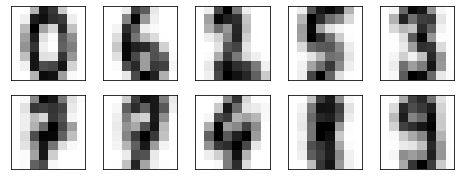

In [12]:
show_centroids(model._centroids)

## Задание 2 (1 балл).

Прочитайте про алгоритм [k-Means++](https://wiki.sc/wikipedia/K-means%2B%2B) и реализуйте его.

In [13]:
class KMeansPlusPlus(TemplateKMeans):
    def __init__(self, n_clusters, iter_num=50):
        super(KMeansPlusPlus, self).__init__(KMeansPlusPlus._init_centroids, 
                                             n_clusters, 
                                             iter_num)
    
    @staticmethod
    def _init_centroids(X, n_clusters):
        centroids = np.zeros((n_clusters, X.shape[1]))
        centroids[0] = X[np.random.randint(X.shape[0]), :]

        for i in range(1, n_clusters):
            distances = np.zeros(X.shape[0])
            for j in range(X.shape[0]):
                point    = X[j, :]
                distance = sys.maxsize

                for k in range(i):
                    distance = min(distance, 
                                   np.linalg.norm(point - centroids[k]))
                distances[j] = distance

            next_centroid = X[np.argmax(distances), :]
            centroids[i] = next_centroid
        return centroids

In [14]:
model = KMeansPlusPlus(10)
model.fit(X_train)

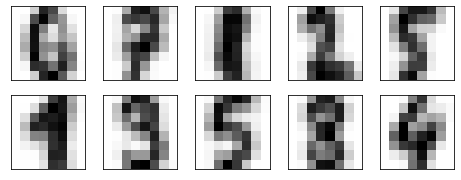

In [15]:
show_centroids(model._centroids)

## Задание 3 (1 балл).

Изобразите исходную выборку (одним цветом) и кластеризованную выборку (каждый кластер своим цветом).

In [16]:
y_pred = model.predict(X_test)

In [17]:
def show_data(X, clusters=None):
    #
    # Захардкожу кол-во кластеров - 10
    # Так проще
    #
    
    cmaps = [plt.cm.Greys,     plt.cm.Blues, 
             plt.cm.Greens,    plt.cm.Reds, 
             plt.cm.autumn_r,  plt.cm.cividis_r, 
             plt.cm.cool_r,    plt.cm.copper_r, 
             plt.cm.inferno_r, plt.cm.cubehelix_r]
    
    clusters = clusters if clusters is not None else [0 for _ in range(X.shape[0])]
    
    cols = X.shape[0] // 10
    fig, ax = plt.subplots(cols, 10, figsize=(16, 3 * cols // 2))
    X_img = X.reshape(X.shape[0], 8, 8)
    for (axi, X_img, cluster) in zip(ax.flat, X_img, clusters):
        axi.set(xticks=[], yticks=[])
        axi.imshow(X_img, interpolation='nearest', cmap=cmaps[cluster])

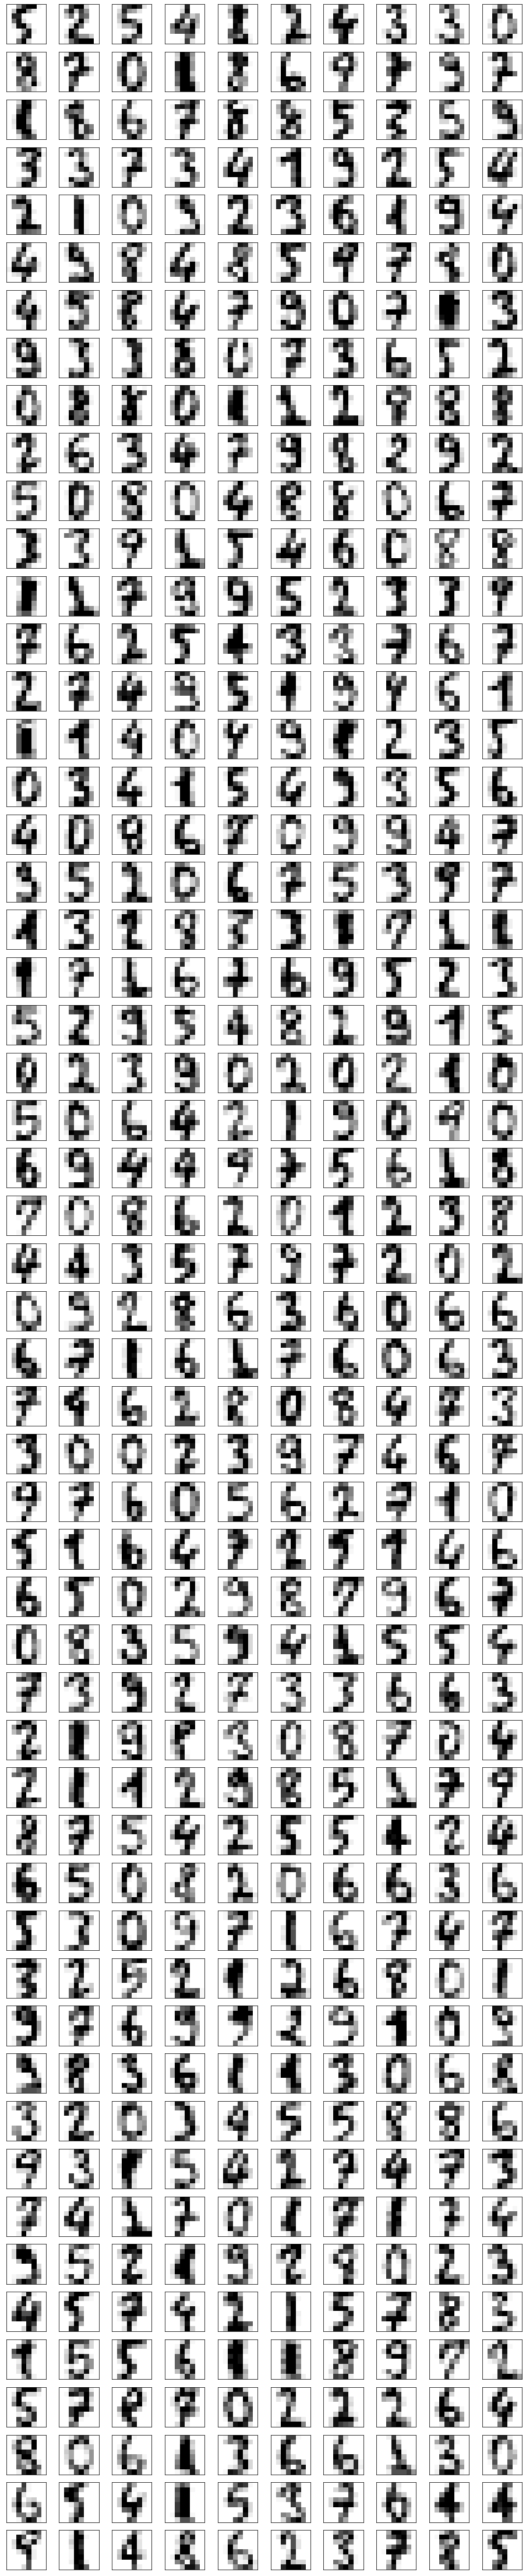

In [18]:
show_data(X_test)

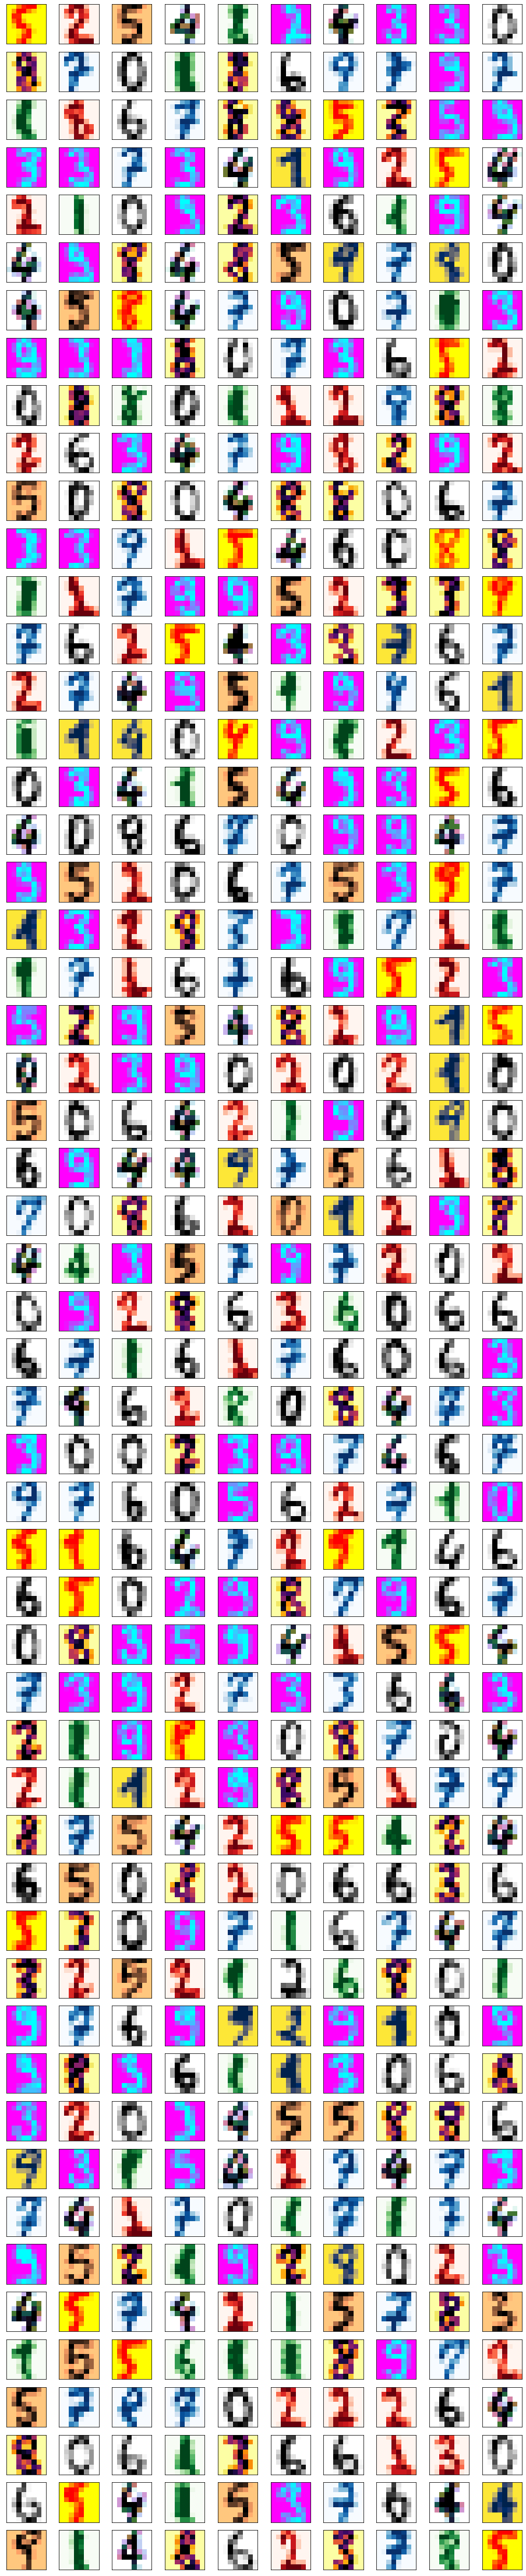

In [19]:
show_data(X_test, y_pred)